In [16]:
import gzip
import numpy as np

# Load the data
with gzip.open("data/train0.gz", "rb") as fd:
    content = fd.readlines()

# Split each line by spaces
vader_nyt = [review.split(b' ') for review in content]

# Decode the bytes to strings
vader_nyt = [[entry.decode('utf-8') for entry in review] for review in vader_nyt]

# Separate labels and features
vader_nyt_labels = np.array([row[0] for row in vader_nyt])

# Remove possible trailing newlines in the last feature
vader_nyt_features = [[float(feat.split(':')[1]) for feat in row[1:]] for row in vader_nyt]

# Convert to numpy array if you want
vader_nyt_features = np.array(vader_nyt_features)

print(vader_nyt_labels.shape)       
print(vader_nyt_features.shape)    
print(vader_nyt_labels[0])         
print(vader_nyt_features[0])       

(3956,)
(3956, 4096)
1
[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
 -1.62006617]


In [17]:
X = vader_nyt_features
y = vader_nyt_labels

In [18]:
print(type(y))
print(y[0:10])
print(type(X))
print(X[0:1])

<class 'numpy.ndarray'>
['1' '1' '1' '0' '0' '0' '0' '1' '0' '1']
<class 'numpy.ndarray'>
[[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
  -1.62006617]]


In [19]:
y = np.array(list(map(int,y)))
print(type(y))
print(y[0:10])

<class 'numpy.ndarray'>
[1 1 1 0 0 0 0 1 0 1]


In [21]:
print(X[y == 0, 0])
print(y[y == 0])

[-1.88623047 -1.49604249 -1.46785402 ... -1.18695927 -1.35992336
  0.2693944 ]
[0 0 0 ... 0 0 0]


(3956, 2)
[34.62419128  3.19151019]


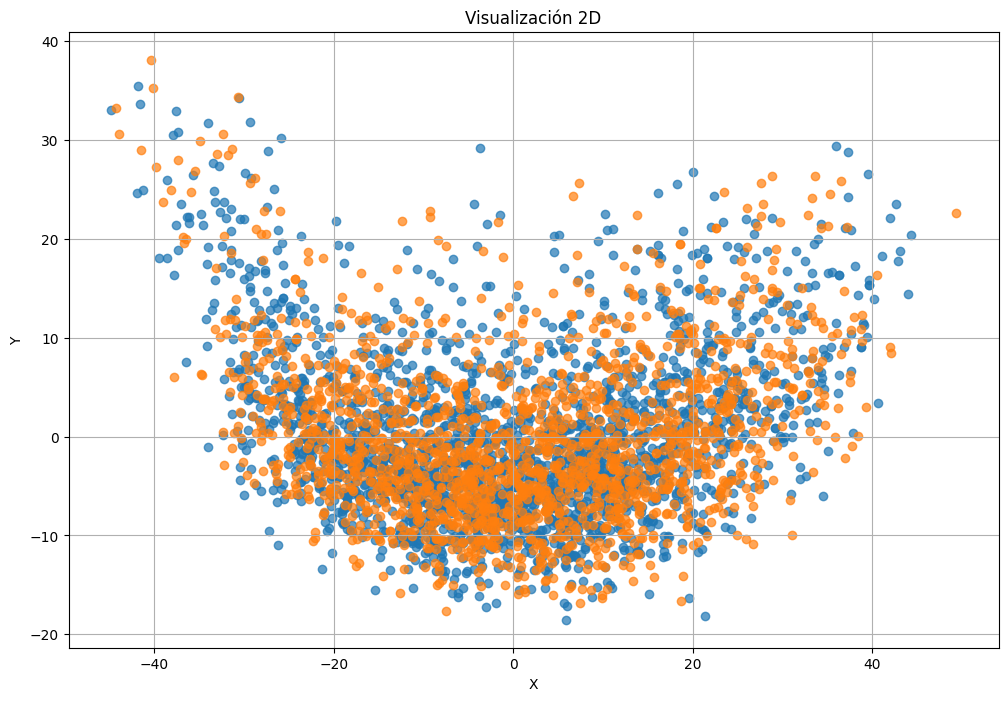

In [22]:
from sklearn.decomposition import PCA

def plot_embs_2d(X, y):

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    print(X_pca.shape)
    print(X_pca[0])

    # Plot
    plt.figure(figsize=(12, 8))
    for i in range(2): # 2 classes
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=f'Class {i}', alpha=0.7)  
        
    plt.title(f"Visualización 2D")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_embs_2d(X, y)

In [25]:
%%time
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# cosine_similarity(X, Y) --> returns ndarray or sparse matrix of shape (n_samples_X, n_samples_Y)
#similarities = cosine_similarity(X, X)
distances = euclidean_distances(X, X)
print(distances[:1])

[[ 0.         49.09521747 56.06615433 ... 48.73090446 49.00718211
  64.87739052]]
CPU times: total: 7.42 s
Wall time: 1.34 s


In [24]:
print(distances[:2])

[[ 0.         49.09521747 56.06615433 ... 48.73090446 49.00718211
  64.87739052]
 [49.09521747  0.         35.8540454  ... 32.56258345 48.29683479
  42.03613854]]


In [30]:
def ne_dist(labels, distances):
    '''
    Vectorized Nearest Enemy computation.
    '''
    labels = np.array(labels)
    n = len(labels)
    ne = np.full(n, -1, dtype=int)

    # Create a mask where entries are True if the pair has different labels
    enemy_mask = labels[:, None] != labels[None, :]

    # Set same-class distances to np.inf to ignore them
    masked_distances = np.where(enemy_mask, distances, np.inf)

    # Find the index of the minimum distance in each row
    ne = np.argmin(masked_distances, axis=1)

    return ne

In [31]:
%%time

nenemies_dist = ne_dist(y, distances)

CPU times: total: 109 ms
Wall time: 117 ms


In [32]:
print(nenemies_dist[:20])

[1792 2120 3682 3327  165 2636  233 2718  102  963  341 1748 3047 1581
 1786  139 2852 2569 3103 1259]


In [36]:
import numpy as np
from collections import defaultdict

def compute_local_sets(labels, ne, distances):
    '''
    Optimized computation of local sets and sorting by decreasing LSC (Local Set Cardinality).
    '''
    labels = np.array(labels)
    ne = np.array(ne)
    distances = np.array(distances)
    n = len(labels)

    LSs = {}
    lsc_map = []

    for i in range(n):
        # Members of same class and closer than nearest enemy
        mask = (labels == labels[i]) & (distances[i] < distances[i][ne[i]])
        LS = np.where(mask)[0].tolist()
        LSs[i] = LS
        lsc_map.append((i, len(LS)))

    # Sort by descending LSC
    lsc_map.sort(key=lambda x: -x[1])

    # Map sorted indices into dictionary format
    sorted_LS_indices_indexed = defaultdict(list)
    for new_index, (original_index, _) in enumerate(lsc_map):
        sorted_LS_indices_indexed[new_index].append(original_index)

    return LSs, sorted_LS_indices_indexed


In [38]:
%%time

LSs, sorted_LSC_indices = compute_local_sets(y, nenemies_dist, distances) 
print(LSs)
print(sorted_LSC_indices)

{0: [0], 1: [1, 2056], 2: [2], 3: [3, 2955], 4: [4, 2985], 5: [5, 426, 2344, 2601], 6: [6, 167, 3193, 3482], 7: [7, 3540], 8: [8, 1549, 3320, 3912], 9: [9, 14], 10: [10, 3504], 11: [11], 12: [12, 1628, 2152], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17, 936], 18: [18], 19: [19, 162, 1211, 1292, 1699, 1999, 2902], 20: [20, 3853], 21: [21, 2353], 22: [22], 23: [23, 25, 554, 1498, 3024, 3306], 24: [24, 571, 1581, 2256, 3152, 3490], 25: [25], 26: [26, 248], 27: [27, 1016, 1495, 2648], 28: [28, 399, 812, 2030, 2237, 2368, 2820, 3775], 29: [27, 29, 1301, 3286], 30: [30, 645], 31: [31], 32: [32, 1202, 1747, 2531, 2847], 33: [33], 34: [34], 35: [35, 36, 1572, 3540], 36: [35, 36, 845, 1572, 3380, 3540], 37: [37], 38: [38], 39: [39, 2055, 2931], 40: [40, 424, 1200, 1367, 2304], 41: [41], 42: [42, 2142, 2304], 43: [43], 44: [44, 3660], 45: [45, 48, 338, 442, 982, 1571, 3665], 46: [46, 1389], 47: [47, 1238], 48: [48, 1894], 49: [49, 600, 917, 1628, 1945, 1973, 2324, 2326], 50: [50], 51: [51, 2

In [39]:
print(len(LSs))

3956


In [43]:
from collections import defaultdict

def LS_based_clustering_INVERSE(sorted_LSC_indices, LSs): 
    '''
    Optimized Local Set Based Clustering (INVERSE)
    '''
    clusters = defaultdict(list)
    included_instances = set()

    # Process clusters from highest to lowest LSC
    for i in sorted(sorted_LSC_indices.keys(), reverse=True):
        for medoid_index in sorted_LSC_indices[i]:
            if medoid_index in included_instances:
                clusters[medoid_index] = []
            else:
                cluster_instances = set(LSs[medoid_index]) - included_instances
                included_instances.update(cluster_instances)
                clusters[medoid_index] = list(cluster_instances)

    return clusters


In [44]:
%%time

clusters_inverse = LS_based_clustering_INVERSE(sorted_LSC_indices, LSs)

CPU times: total: 0 ns
Wall time: 7.5 ms


In [45]:
print(clusters_inverse)

defaultdict(<class 'list'>, {3499: [], 3496: [], 2703: [], 2700: [], 2172: [], 2168: [], 494: [], 490: [], 3955: [3955], 3954: [3954], 3952: [3952], 3950: [3950], 3947: [3947], 3946: [3946], 3943: [3943], 3941: [3941], 3939: [3939], 3935: [3935], 3931: [3931], 3928: [3928], 3924: [3924], 3921: [3921], 3919: [3919], 3918: [3918], 3917: [3917], 3914: [3914], 3908: [3908], 3906: [3906], 3903: [3903], 3900: [3900], 3899: [3899], 3895: [3895], 3894: [3894], 3893: [3893], 3892: [3892], 3890: [3890], 3889: [3889], 3886: [3886], 3883: [3883], 3882: [3882], 3875: [3875], 3874: [3874], 3868: [3868], 3867: [3867], 3866: [3866], 3864: [3864], 3862: [3862], 3860: [3860], 3858: [3858], 3856: [3856], 3850: [3850], 3849: [3849], 3848: [3848], 3846: [3846], 3845: [3845], 3843: [3843], 3830: [3830], 3829: [3829], 3827: [3827], 3826: [3826], 3825: [3825], 3823: [3823], 3817: [3817], 3815: [3815], 3812: [3812], 3811: [3811], 3809: [3809], 3807: [3807], 3806: [3806], 3805: [3805], 3800: [3800], 3799: [3799

In [46]:
# TODO


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

def plot_clusters(clusters, X, y, ne, max_medoid_circles=20, show_labels=False):
    '''
    Optimized cluster visualization for large datasets.
    - Only shows medoid circles for a limited number of medoids.
    - Point labels are optional.
    '''
    fig, ax = plt.subplots(figsize=(12, 12))
    X = np.array(X)
    y = np.array(y)
    colors = plt.cm.get_cmap("tab20", len(clusters))

    legend_handles = []
    
    for idx, (medoid, members) in enumerate(clusters.items()):
        if not members:
            continue
        
        color = colors(idx)
        legend_handles.append(mpatches.Patch(color=color, label=f"Medoid {medoid}"))
        
        cluster_points = X[members]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, s=30, alpha=0.6)

        # Draw medoid circle if not too many
        if idx < max_medoid_circles:
            center = X[medoid]
            radius = math.dist(center, X[ne[medoid]])
            circle = plt.Circle(center, radius, edgecolor=color, fill=False, linewidth=1.2, linestyle='--')
            ax.add_patch(circle)
        
        if show_labels:
            for i in members:
                ax.text(X[i, 0], X[i, 1], str(i), fontsize=6, ha='center', va='center', color='black')

    ax.set_aspect('equal')
    ax.legend(handles=legend_handles, loc='best', fontsize=8)
    ax.grid(True)
    plt.title("Cluster Visualization (Optimized)")
    plt.show()


In [47]:
%%time

plot_clusters(clusters_inverse, X, y, nenemies_dist)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13744\3856415266.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(clusters))


CPU times: total: 2min 6s
Wall time: 2min 7s


In [48]:
print(clusters_inverse.keys())
for key in clusters_inverse:
    print(clusters_inverse[key])

dict_keys([3499, 3496, 2703, 2700, 2172, 2168, 494, 490, 3955, 3954, 3952, 3950, 3947, 3946, 3943, 3941, 3939, 3935, 3931, 3928, 3924, 3921, 3919, 3918, 3917, 3914, 3908, 3906, 3903, 3900, 3899, 3895, 3894, 3893, 3892, 3890, 3889, 3886, 3883, 3882, 3875, 3874, 3868, 3867, 3866, 3864, 3862, 3860, 3858, 3856, 3850, 3849, 3848, 3846, 3845, 3843, 3830, 3829, 3827, 3826, 3825, 3823, 3817, 3815, 3812, 3811, 3809, 3807, 3806, 3805, 3800, 3799, 3798, 3796, 3795, 3794, 3792, 3791, 3786, 3782, 3779, 3778, 3777, 3774, 3770, 3768, 3767, 3765, 3762, 3761, 3759, 3757, 3756, 3755, 3754, 3745, 3743, 3742, 3740, 3735, 3733, 3728, 3727, 3726, 3724, 3722, 3718, 3714, 3712, 3710, 3708, 3704, 3699, 3696, 3695, 3694, 3693, 3692, 3686, 3684, 3681, 3680, 3678, 3676, 3675, 3674, 3673, 3669, 3668, 3667, 3665, 3662, 3660, 3659, 3656, 3655, 3654, 3652, 3647, 3645, 3644, 3638, 3637, 3636, 3633, 3632, 3630, 3624, 3619, 3618, 3615, 3608, 3606, 3600, 3587, 3586, 3583, 3582, 3580, 3579, 3576, 3574, 3572, 3571, 3569, 3

In [49]:
clusters_inverse_clean = defaultdict(list)
for key in clusters_inverse:
    if(len(clusters_inverse[key]) != 0):
        clusters_inverse_clean[key] = clusters_inverse[key] # add cluster

In [50]:
print(clusters_inverse_clean.keys())
for key in clusters_inverse_clean:
    print(clusters_inverse_clean[key])

dict_keys([3955, 3954, 3952, 3950, 3947, 3946, 3943, 3941, 3939, 3935, 3931, 3928, 3924, 3921, 3919, 3918, 3917, 3914, 3908, 3906, 3903, 3900, 3899, 3895, 3894, 3893, 3892, 3890, 3889, 3886, 3883, 3882, 3875, 3874, 3868, 3867, 3866, 3864, 3862, 3860, 3858, 3856, 3850, 3849, 3848, 3846, 3845, 3843, 3830, 3829, 3827, 3826, 3825, 3823, 3817, 3815, 3812, 3811, 3809, 3807, 3806, 3805, 3800, 3799, 3798, 3796, 3795, 3794, 3792, 3791, 3786, 3782, 3779, 3778, 3777, 3774, 3770, 3768, 3767, 3765, 3762, 3761, 3759, 3757, 3756, 3755, 3754, 3745, 3743, 3742, 3740, 3735, 3733, 3728, 3727, 3726, 3724, 3722, 3718, 3714, 3712, 3710, 3708, 3704, 3699, 3696, 3695, 3694, 3693, 3692, 3686, 3684, 3681, 3680, 3678, 3676, 3675, 3674, 3673, 3669, 3668, 3667, 3665, 3662, 3660, 3659, 3656, 3655, 3654, 3652, 3647, 3645, 3644, 3638, 3637, 3636, 3633, 3632, 3630, 3624, 3619, 3618, 3615, 3608, 3606, 3600, 3587, 3586, 3583, 3582, 3580, 3579, 3576, 3574, 3572, 3571, 3569, 3563, 3562, 3560, 3557, 3551, 3549, 3548, 3546,

In [51]:
num_decision_variables = 150
size = min(len(clusters_inverse_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

initial number of clusters: 3325 
number of decision variables:150 
final size: 150


In [52]:
# sort keys by cluster cardinality
key_cardinality = list(map(lambda key, value: [key, len(value)], list(clusters_inverse_clean.keys()), list(clusters_inverse_clean.values())))
print(key_cardinality)

[[3955, 1], [3954, 1], [3952, 1], [3950, 1], [3947, 1], [3946, 1], [3943, 1], [3941, 1], [3939, 1], [3935, 1], [3931, 1], [3928, 1], [3924, 1], [3921, 1], [3919, 1], [3918, 1], [3917, 1], [3914, 1], [3908, 1], [3906, 1], [3903, 1], [3900, 1], [3899, 1], [3895, 1], [3894, 1], [3893, 1], [3892, 1], [3890, 1], [3889, 1], [3886, 1], [3883, 1], [3882, 1], [3875, 1], [3874, 1], [3868, 1], [3867, 1], [3866, 1], [3864, 1], [3862, 1], [3860, 1], [3858, 1], [3856, 1], [3850, 1], [3849, 1], [3848, 1], [3846, 1], [3845, 1], [3843, 1], [3830, 1], [3829, 1], [3827, 1], [3826, 1], [3825, 1], [3823, 1], [3817, 1], [3815, 1], [3812, 1], [3811, 1], [3809, 1], [3807, 1], [3806, 1], [3805, 1], [3800, 1], [3799, 1], [3798, 1], [3796, 1], [3795, 1], [3794, 1], [3792, 1], [3791, 1], [3786, 1], [3782, 1], [3779, 1], [3778, 1], [3777, 1], [3774, 1], [3770, 1], [3768, 1], [3767, 1], [3765, 1], [3762, 1], [3761, 1], [3759, 1], [3757, 1], [3756, 1], [3755, 1], [3754, 1], [3745, 1], [3743, 1], [3742, 1], [3740, 1]

In [53]:
key_cardinality_inverse = list(map(lambda row: [row[1],row[0]], key_cardinality))

print(key_cardinality_inverse)
key_cardinality_inverse.sort()
print(key_cardinality_inverse)

[[1, 3955], [1, 3954], [1, 3952], [1, 3950], [1, 3947], [1, 3946], [1, 3943], [1, 3941], [1, 3939], [1, 3935], [1, 3931], [1, 3928], [1, 3924], [1, 3921], [1, 3919], [1, 3918], [1, 3917], [1, 3914], [1, 3908], [1, 3906], [1, 3903], [1, 3900], [1, 3899], [1, 3895], [1, 3894], [1, 3893], [1, 3892], [1, 3890], [1, 3889], [1, 3886], [1, 3883], [1, 3882], [1, 3875], [1, 3874], [1, 3868], [1, 3867], [1, 3866], [1, 3864], [1, 3862], [1, 3860], [1, 3858], [1, 3856], [1, 3850], [1, 3849], [1, 3848], [1, 3846], [1, 3845], [1, 3843], [1, 3830], [1, 3829], [1, 3827], [1, 3826], [1, 3825], [1, 3823], [1, 3817], [1, 3815], [1, 3812], [1, 3811], [1, 3809], [1, 3807], [1, 3806], [1, 3805], [1, 3800], [1, 3799], [1, 3798], [1, 3796], [1, 3795], [1, 3794], [1, 3792], [1, 3791], [1, 3786], [1, 3782], [1, 3779], [1, 3778], [1, 3777], [1, 3774], [1, 3770], [1, 3768], [1, 3767], [1, 3765], [1, 3762], [1, 3761], [1, 3759], [1, 3757], [1, 3756], [1, 3755], [1, 3754], [1, 3745], [1, 3743], [1, 3742], [1, 3740]

In [54]:
clusters_preselected = defaultdict(list)
for i in range(size):
    key = key_cardinality_inverse[i][1]
    clusters_preselected[key] = clusters_inverse_clean[key]
print(clusters_preselected)
print(len(clusters_preselected))

defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 4: [4], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 29: [29], 31: [31], 33: [33], 34: [34], 37: [37], 38: [38], 40: [40], 41: [41], 42: [42], 43: [43], 44: [44], 48: [48], 49: [49], 50: [50], 51: [51], 52: [52], 55: [55], 56: [56], 57: [57], 59: [59], 60: [60], 61: [61], 62: [62], 66: [66], 67: [67], 68: [68], 69: [69], 70: [70], 72: [72], 74: [74], 75: [75], 76: [76], 77: [77], 78: [78], 80: [80], 81: [81], 83: [83], 86: [86], 87: [87], 88: [88], 90: [90], 91: [91], 92: [92], 94: [94], 96: [96], 97: [97], 99: [99], 100: [100], 102: [102], 103: [103], 104: [104], 105: [105], 107: [107], 110: [110], 111: [111], 113: [113], 114: [114], 115: [115], 117: [117], 120: [120], 121: [121], 122: [122], 123: [123], 124: [124], 125: [125], 126: [126], 128: [128], 131: [131], 134: [134], 135: [135], 136: [136

In [55]:
%%time

has_ne_of = [[0 for _ in range(size)] for _ in range(size)]
has_LS_member = [[0 for _ in range(size)] for _ in range(size)]

for i in range(size):
    cluster_i_components = list(clusters_preselected.values())[i]

    for j in range(i+1, size): # for each different pair of clusters
        cluster_j_components = list(clusters_preselected.values())[j]
        for comp_i in cluster_i_components:
            for comp_j in cluster_j_components:  

                    if(nenemies_dist[comp_j] == comp_i): # cluster i has a ne of cluster j
                        has_ne_of[i][j] = has_ne_of[i][j] + 1 
                        
                    if(nenemies_dist[comp_i] == comp_j): # cluster j has a ne of cluster i
                        has_ne_of[j][i] = has_ne_of[j][i] + 1 
                        
                    if(comp_i in LSs[comp_j]): # cluster i has a member of a LS of cluster j
                        has_LS_member[i][j] = has_LS_member[i][j] + 1
                        
                    if(comp_j in LSs[comp_i]): # cluster j has a member of a LS of cluster i
                        has_LS_member[j][i] = has_LS_member[j][i] + 1 
                    
import numpy as np  

print(f'cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): \n {np.array(has_ne_of)}')
print()
print(f'cluster members of LSs of other clusters: \n {np.array(has_LS_member)}') # Comment: take into account that LS with higher cardinality have higher LS intersection

cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

cluster members of LSs of other clusters: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
CPU times: total: 46.9 ms
Wall time: 48.2 ms


In [56]:
%%time

total_cluster_nes = list(map(sum, has_ne_of))
total_cluster_LSs_members = list(map(sum, has_LS_member)) 
#cluster_noise_score = list(map(lambda a, b: a-b, total_cluster_ne, total_cluster_LS))

has_a_ne = list(map(lambda a: 0 if a == 0 else 1, total_cluster_nes))
has_a_LS_member = list(map(lambda a: 0 if a == 0 else 1, total_cluster_LSs_members))

print(f'total cluster nearest ennemies: \n {np.array(total_cluster_nes)}')
print()
print(f'total cluster members belonging to Local Sets: \n {np.array(total_cluster_LSs_members)}') 
print()
print(f'clusters having nearest ennemies: \n {np.array(has_a_ne)}')
print()
print(f'clusters having members belonging to Local Sets: \n {np.array(has_a_LS_member)}')       

total cluster nearest ennemies: 
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0]

total cluster members belonging to Local Sets: 
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]

clusters having nearest ennemies: 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [57]:
clusters_filtered = defaultdict(list)
filtered_keys = list(map(lambda key, LS_members, nearest_ennemies: key if LS_members >= nearest_ennemies else -1, clusters_preselected.keys(), total_cluster_LSs_members, total_cluster_nes))
print(filtered_keys)

[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, -1, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, -1, 33, 34, 37, 38, 40, -1, 42, 43, 44, 48, -1, 50, 51, 52, 55, 56, 57, 59, 60, 61, 62, 66, 67, 68, -1, -1, 72, 74, 75, 76, 77, 78, 80, 81, 83, 86, 87, 88, 90, 91, 92, 94, 96, 97, 99, 100, -1, 103, 104, 105, 107, 110, 111, 113, 114, 115, 117, 120, 121, 122, 123, 124, 125, 126, 128, 131, 134, 135, 136, 137, 138, -1, 140, 141, 143, 144, 145, 147, 148, 149, 150, 153, 154, 155, 157, 160, 162, 163, 166, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 188, 191, 192, 196, 197, 198, 199, -1, 202, 205, 206, 207, 208, 209, 210, 211, 214, 215, 218, 219]


In [58]:
for key in filtered_keys:
    if key != -1:
        clusters_filtered[key] = clusters_preselected[key]

print(clusters_filtered)

defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 4: [4], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 22: [22], 23: [23], 24: [24], 25: [25], 26: [26], 29: [29], 33: [33], 34: [34], 37: [37], 38: [38], 40: [40], 42: [42], 43: [43], 44: [44], 48: [48], 50: [50], 51: [51], 52: [52], 55: [55], 56: [56], 57: [57], 59: [59], 60: [60], 61: [61], 62: [62], 66: [66], 67: [67], 68: [68], 72: [72], 74: [74], 75: [75], 76: [76], 77: [77], 78: [78], 80: [80], 81: [81], 83: [83], 86: [86], 87: [87], 88: [88], 90: [90], 91: [91], 92: [92], 94: [94], 96: [96], 97: [97], 99: [99], 100: [100], 103: [103], 104: [104], 105: [105], 107: [107], 110: [110], 111: [111], 113: [113], 114: [114], 115: [115], 117: [117], 120: [120], 121: [121], 122: [122], 123: [123], 124: [124], 125: [125], 126: [126], 128: [128], 131: [131], 134: [134], 135: [135], 136: [136], 137: [137], 138: [138], 140: [140], 141: [141], 143: [143], 144: [144

In [59]:
filtered_instances = []
for cluster_members in list(clusters_filtered.values()):
    filtered_instances = filtered_instances + cluster_members
print(filtered_instances)

[0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, 33, 34, 37, 38, 40, 42, 43, 44, 48, 50, 51, 52, 55, 56, 57, 59, 60, 61, 62, 66, 67, 68, 72, 74, 75, 76, 77, 78, 80, 81, 83, 86, 87, 88, 90, 91, 92, 94, 96, 97, 99, 100, 103, 104, 105, 107, 110, 111, 113, 114, 115, 117, 120, 121, 122, 123, 124, 125, 126, 128, 131, 134, 135, 136, 137, 138, 140, 141, 143, 144, 145, 147, 148, 149, 150, 153, 154, 155, 157, 160, 162, 163, 166, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 188, 191, 192, 196, 197, 198, 199, 202, 205, 206, 207, 208, 209, 210, 211, 214, 215, 218, 219]


In [60]:
selected_indices_dict = defaultdict(list)
for new_i, old_i in enumerate(filtered_instances):
    selected_indices_dict[new_i] = old_i

print(selected_indices_dict)

defaultdict(<class 'list'>, {0: 0, 1: 1, 2: 2, 3: 4, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 13, 11: 14, 12: 16, 13: 17, 14: 18, 15: 19, 16: 20, 17: 22, 18: 23, 19: 24, 20: 25, 21: 26, 22: 29, 23: 33, 24: 34, 25: 37, 26: 38, 27: 40, 28: 42, 29: 43, 30: 44, 31: 48, 32: 50, 33: 51, 34: 52, 35: 55, 36: 56, 37: 57, 38: 59, 39: 60, 40: 61, 41: 62, 42: 66, 43: 67, 44: 68, 45: 72, 46: 74, 47: 75, 48: 76, 49: 77, 50: 78, 51: 80, 52: 81, 53: 83, 54: 86, 55: 87, 56: 88, 57: 90, 58: 91, 59: 92, 60: 94, 61: 96, 62: 97, 63: 99, 64: 100, 65: 103, 66: 104, 67: 105, 68: 107, 69: 110, 70: 111, 71: 113, 72: 114, 73: 115, 74: 117, 75: 120, 76: 121, 77: 122, 78: 123, 79: 124, 80: 125, 81: 126, 82: 128, 83: 131, 84: 134, 85: 135, 86: 136, 87: 137, 88: 138, 89: 140, 90: 141, 91: 143, 92: 144, 93: 145, 94: 147, 95: 148, 96: 149, 97: 150, 98: 153, 99: 154, 100: 155, 101: 157, 102: 160, 103: 162, 104: 163, 105: 166, 106: 168, 107: 169, 108: 170, 109: 171, 110: 172, 111: 174, 112: 175, 113: 176, 114: 177, 11

In [61]:
X_filtered = X[filtered_instances]
y_filtered = y[filtered_instances]
print(len(X_filtered))
print(len(y_filtered))
print(X_filtered)
print(y_filtered)

141
141
[[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
  -1.62006617]
 [-0.88396335 -1.9474721   2.5859375  ...  0.46487188 -0.53671646
  -0.5849793 ]
 [-1.40904236 -1.81700516  2.16044235 ...  1.21251297  0.0691561
   0.49760771]
 ...
 [-0.93161249 -1.85645056  0.88852882 ...  1.15511751  0.71613693
   0.15787005]
 [-0.38388228 -4.067307    2.28537941 ...  2.05960846 -0.68480206
  -2.70298386]
 [-0.95235991 -1.84865808  2.64262199 ...  1.61412811 -0.15414746
   0.42134237]]
[1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0
 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0
 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1]


(141, 2)
[36.78470455 -0.66658484]


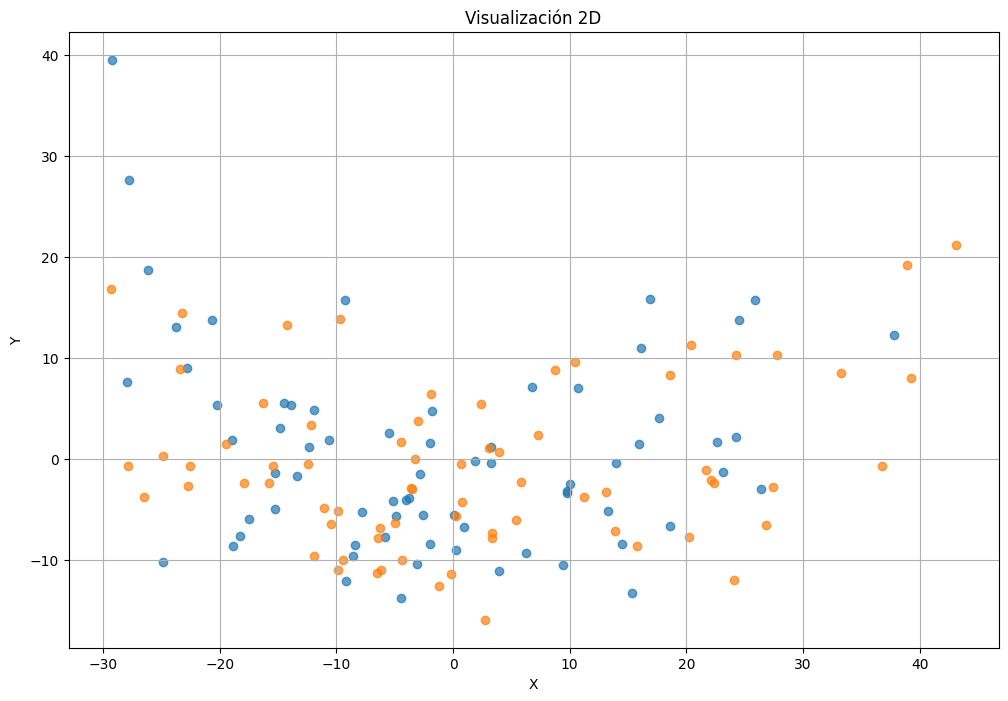

In [62]:
plot_embs_2d(X_filtered, y_filtered)

In [63]:
distances_filtered = euclidean_distances(X_filtered, X_filtered)
print(distances_filtered.shape)
nenemies_dist_filtered = ne_dist(y_filtered, distances_filtered)
print(nenemies_dist_filtered)
print(len(nenemies_dist_filtered))

(141, 141)
[ 39  86  73 126  21  90  67  56 102  73  38 103  13  11  11  11  63  47
  43  22 126  11  19  70  85  39  28  23  23  28 125  39  86  86 120 110
  35  79   8  31 117  39  83  34  23 121  54 114  35  59 133  77  86  73
  84 102  90  33  62  64  62  23  67  87   8 103  75  11  78  63  23  11
  19  11  34  84  63  68  68  11  11  78  57  42  70  86  33  63 110  38
  63 106   2  39  86   2  70  19  96  37 128 103   8  11  12  75  73 109
  90 107  35  82 106  35 115 110  30 110 119 114  30 122 121 110  86  30
  20  33 110  87  23 101 137  50  61  63  86  23  47  34  73]
141


In [64]:
LSs_filtered, sorted_LSC_indices_filtered = compute_local_sets(y_filtered, nenemies_dist_filtered, distances_filtered) 
print(LSs_filtered)
print(sorted_LSC_indices_filtered)

{0: [0, 120, 125], 1: [1, 85], 2: [2], 3: [3, 20], 4: [4], 5: [5], 6: [6, 11], 7: [7, 90], 8: [8], 9: [9, 23, 83, 84], 10: [8, 10, 22, 75], 11: [11], 12: [11, 12], 13: [13], 14: [8, 14], 15: [13, 15, 80, 103], 16: [16, 35, 69, 90], 17: [17, 138], 18: [18, 20, 72], 19: [19, 66], 20: [20, 72], 21: [21, 110], 22: [22, 61, 103], 23: [23], 24: [24, 28, 67], 25: [25], 26: [26], 27: [27, 73], 28: [24, 28, 57, 67, 73, 79, 86, 91], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34], 35: [35], 36: [36, 109, 110], 37: [11, 37], 38: [38, 102], 39: [39], 40: [40], 41: [41, 93, 96], 42: [42], 43: [43, 139], 44: [8, 44, 55], 45: [45], 46: [46], 47: [47, 119], 48: [48], 49: [49], 50: [50], 51: [11, 51, 87, 107], 52: [2, 11, 29, 32, 51, 52, 53, 88, 107, 135], 53: [2, 11, 23, 53], 54: [54], 55: [55], 56: [56], 57: [57], 58: [58, 60, 78], 59: [30, 59], 60: [58, 60], 61: [61], 62: [62], 63: [63, 67, 73, 133], 64: [31, 64, 102], 65: [65], 66: [66], 67: [67, 73], 68: [68], 69: [35, 69, 90], 70: [70]

In [65]:
print(len(LSs_filtered))

141


In [66]:
clusters_inverse_filtered = LS_based_clustering_INVERSE(sorted_LSC_indices_filtered, LSs_filtered)

In [67]:
print(clusters_inverse_filtered)

defaultdict(<class 'list'>, {140: [140], 138: [138], 134: [134], 127: [127], 126: [126], 125: [125], 124: [124], 123: [123], 122: [122], 121: [121], 120: [120], 119: [119], 117: [117], 116: [116], 113: [113], 110: [110], 108: [108], 106: [106], 104: [104], 102: [102], 101: [101], 98: [98], 97: [97], 96: [96], 88: [88], 86: [86], 81: [81], 70: [70], 68: [68], 66: [66], 65: [65], 62: [62], 61: [61], 57: [57], 56: [56], 55: [55], 54: [54], 50: [50], 49: [49], 48: [48], 46: [46], 45: [45], 42: [42], 40: [40], 39: [39], 35: [35], 34: [34], 33: [33], 32: [32], 31: [31], 30: [30], 29: [29], 26: [26], 25: [25], 23: [23], 13: [13], 11: [11], 8: [8], 5: [5], 4: [4], 2: [2], 139: [43, 139], 137: [137, 20], 136: [136], 133: [129, 133], 129: [], 128: [128], 118: [114, 118], 114: [], 109: [109], 107: [107], 103: [80, 103], 94: [94], 87: [87], 85: [85], 84: [84], 83: [9, 83], 78: [78], 77: [77], 76: [76], 75: [75], 74: [0, 74], 67: [73, 67], 60: [58, 60], 59: [59], 47: [47], 43: [], 38: [38], 37: [37

In [68]:
clusters_inverse_filtered_clean = defaultdict(list)
for key in clusters_inverse_filtered:
    if(len(clusters_inverse_filtered[key]) != 0):
        clusters_inverse_filtered_clean[key] = clusters_inverse_filtered[key] # add cluster

In [69]:
print(clusters_inverse_filtered_clean.keys())
for key in clusters_inverse_filtered_clean:
    print(clusters_inverse_filtered_clean[key])

dict_keys([140, 138, 134, 127, 126, 125, 124, 123, 122, 121, 120, 119, 117, 116, 113, 110, 108, 106, 104, 102, 101, 98, 97, 96, 88, 86, 81, 70, 68, 66, 65, 62, 61, 57, 56, 55, 54, 50, 49, 48, 46, 45, 42, 40, 39, 35, 34, 33, 32, 31, 30, 29, 26, 25, 23, 13, 11, 8, 5, 4, 2, 139, 137, 136, 133, 128, 118, 109, 107, 103, 94, 87, 85, 84, 83, 78, 77, 76, 75, 74, 67, 60, 59, 47, 38, 37, 27, 21, 19, 17, 14, 12, 7, 6, 3, 1, 132, 112, 105, 99, 82, 79, 72, 71, 69, 64, 44, 41, 36, 24, 22, 18, 135, 131, 115, 100, 95, 89, 63, 53, 51, 16, 15, 10, 130, 52])
[140]
[138]
[134]
[127]
[126]
[125]
[124]
[123]
[122]
[121]
[120]
[119]
[117]
[116]
[113]
[110]
[108]
[106]
[104]
[102]
[101]
[98]
[97]
[96]
[88]
[86]
[81]
[70]
[68]
[66]
[65]
[62]
[61]
[57]
[56]
[55]
[54]
[50]
[49]
[48]
[46]
[45]
[42]
[40]
[39]
[35]
[34]
[33]
[32]
[31]
[30]
[29]
[26]
[25]
[23]
[13]
[11]
[8]
[5]
[4]
[2]
[43, 139]
[137, 20]
[136]
[129, 133]
[128]
[114, 118]
[109]
[107]
[80, 103]
[94]
[87]
[85]
[84]
[9, 83]
[78]
[77]
[76]
[75]
[0, 74]


In [70]:
num_decision_variables = 150
size = min(len(clusters_inverse_filtered_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_filtered_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

initial number of clusters: 126 
number of decision variables:150 
final size: 126


In [71]:
# sort keys by cluster cardinality
key_cardinality = list(map(lambda key, value: [key, len(value)], list(clusters_inverse_filtered_clean.keys()), list(clusters_inverse_filtered_clean.values())))
print(key_cardinality)
print(len(key_cardinality))

[[140, 1], [138, 1], [134, 1], [127, 1], [126, 1], [125, 1], [124, 1], [123, 1], [122, 1], [121, 1], [120, 1], [119, 1], [117, 1], [116, 1], [113, 1], [110, 1], [108, 1], [106, 1], [104, 1], [102, 1], [101, 1], [98, 1], [97, 1], [96, 1], [88, 1], [86, 1], [81, 1], [70, 1], [68, 1], [66, 1], [65, 1], [62, 1], [61, 1], [57, 1], [56, 1], [55, 1], [54, 1], [50, 1], [49, 1], [48, 1], [46, 1], [45, 1], [42, 1], [40, 1], [39, 1], [35, 1], [34, 1], [33, 1], [32, 1], [31, 1], [30, 1], [29, 1], [26, 1], [25, 1], [23, 1], [13, 1], [11, 1], [8, 1], [5, 1], [4, 1], [2, 1], [139, 2], [137, 2], [136, 1], [133, 2], [128, 1], [118, 2], [109, 1], [107, 1], [103, 2], [94, 1], [87, 1], [85, 1], [84, 1], [83, 2], [78, 1], [77, 1], [76, 1], [75, 1], [74, 2], [67, 2], [60, 2], [59, 1], [47, 1], [38, 1], [37, 1], [27, 1], [21, 1], [19, 1], [17, 1], [14, 1], [12, 1], [7, 2], [6, 1], [3, 1], [1, 1], [132, 2], [112, 3], [105, 1], [99, 1], [82, 1], [79, 1], [72, 1], [71, 1], [69, 1], [64, 1], [44, 1], [41, 1], [3

In [72]:
key_cardinality_inverse = list(map(lambda row: [row[1],row[0]], key_cardinality))

print(key_cardinality_inverse)
print(len(key_cardinality_inverse))
key_cardinality_inverse.sort()
print(key_cardinality_inverse)

[[1, 140], [1, 138], [1, 134], [1, 127], [1, 126], [1, 125], [1, 124], [1, 123], [1, 122], [1, 121], [1, 120], [1, 119], [1, 117], [1, 116], [1, 113], [1, 110], [1, 108], [1, 106], [1, 104], [1, 102], [1, 101], [1, 98], [1, 97], [1, 96], [1, 88], [1, 86], [1, 81], [1, 70], [1, 68], [1, 66], [1, 65], [1, 62], [1, 61], [1, 57], [1, 56], [1, 55], [1, 54], [1, 50], [1, 49], [1, 48], [1, 46], [1, 45], [1, 42], [1, 40], [1, 39], [1, 35], [1, 34], [1, 33], [1, 32], [1, 31], [1, 30], [1, 29], [1, 26], [1, 25], [1, 23], [1, 13], [1, 11], [1, 8], [1, 5], [1, 4], [1, 2], [2, 139], [2, 137], [1, 136], [2, 133], [1, 128], [2, 118], [1, 109], [1, 107], [2, 103], [1, 94], [1, 87], [1, 85], [1, 84], [2, 83], [1, 78], [1, 77], [1, 76], [1, 75], [2, 74], [2, 67], [2, 60], [1, 59], [1, 47], [1, 38], [1, 37], [1, 27], [1, 21], [1, 19], [1, 17], [1, 14], [1, 12], [2, 7], [1, 6], [1, 3], [1, 1], [2, 132], [3, 112], [1, 105], [1, 99], [1, 82], [1, 79], [1, 72], [1, 71], [1, 69], [1, 64], [1, 44], [1, 41], [1

In [73]:
clusters_filtered_preselected = defaultdict(list)
for i in range(size):
    key = key_cardinality_inverse[i][1]
    clusters_filtered_preselected[key] = clusters_inverse_filtered_clean[key]
print(clusters_filtered_preselected)
print(len(clusters_filtered_preselected))

defaultdict(<class 'list'>, {1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 8: [8], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 21: [21], 22: [22], 23: [23], 25: [25], 26: [26], 27: [27], 29: [29], 30: [30], 31: [31], 32: [32], 33: [33], 34: [34], 35: [35], 36: [36], 37: [37], 38: [38], 39: [39], 40: [40], 41: [41], 42: [42], 44: [44], 45: [45], 46: [46], 47: [47], 48: [48], 49: [49], 50: [50], 51: [51], 52: [52], 53: [53], 54: [54], 55: [55], 56: [56], 57: [57], 59: [59], 61: [61], 62: [62], 63: [63], 64: [64], 65: [65], 66: [66], 68: [68], 69: [69], 70: [70], 71: [71], 72: [72], 75: [75], 76: [76], 77: [77], 78: [78], 79: [79], 81: [81], 82: [82], 84: [84], 85: [85], 86: [86], 87: [87], 88: [88], 89: [89], 94: [94], 96: [96], 97: [97], 98: [98], 99: [99], 100: [100], 101: [101], 102: [102], 104: [104], 105: [105], 106: [106], 107: [107], 108: [108], 109: [109], 110: [110], 113: [113], 115: [115], 116: [116], 117: [117], 119: [1

In [74]:
selected_y = list(int(y_filtered[i]) for i in list(clusters_filtered_preselected.keys()))
selected_y = np.array(selected_y)

In [75]:
print(clusters_filtered_preselected.keys())
print(y_filtered)
print(selected_y)
print(len(selected_y))
print(type(y_filtered))
print(type(selected_y))

dict_keys([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 94, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 134, 135, 136, 138, 140, 7, 24, 60, 67, 74, 83, 95, 103, 118, 132, 133, 137, 139, 112])
[1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0
 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0
 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1]
[1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0
 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1
 1 0 1 1 0 0 0 0 

In [76]:
has_ne_of = [[0 for _ in range(size)] for _ in range(size)]
has_LS_member = [[0 for _ in range(size)] for _ in range(size)]

for i in range(size):
    cluster_i_components = list(clusters_filtered_preselected.values())[i]

    for j in range(i+1, size): # for each different pair of clusters
        cluster_j_components = list(clusters_filtered_preselected.values())[j]
        for comp_i in cluster_i_components:
            for comp_j in cluster_j_components:  

                    if(nenemies_dist_filtered[comp_j] == comp_i): # cluster i has a ne of cluster j
                        has_ne_of[i][j] = has_ne_of[i][j] + 1 
                        
                    if(nenemies_dist_filtered[comp_i] == comp_j): # cluster j has a ne of cluster i
                        has_ne_of[j][i] = has_ne_of[j][i] + 1 
                        
                    if(comp_i in LSs_filtered[comp_j]): # cluster i has a member of a LS of cluster j
                        has_LS_member[i][j] = has_LS_member[i][j] + 1
                        
                    if(comp_j in LSs_filtered[comp_i]): # cluster j has a member of a LS of cluster i
                        has_LS_member[j][i] = has_LS_member[j][i] + 1 
                    
import numpy as np  

print(f'cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): \n {np.array(has_ne_of)}')
print()
print(f'cluster members of LSs of other clusters: \n {np.array(has_LS_member)}') # Comment: take into account that LS with higher cardinality have higher LS intersection

cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

cluster members of LSs of other clusters: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [77]:
total_cluster_nes = list(map(sum, has_ne_of))
total_cluster_LSs_members = list(map(sum, has_LS_member)) 
#cluster_noise_score = list(map(lambda a, b: a-b, total_cluster_ne, total_cluster_LS))

has_a_ne = list(map(lambda a: 0 if a == 0 else 1, total_cluster_nes))
has_a_LS_member = list(map(lambda a: 0 if a == 0 else 1, total_cluster_LSs_members))

print(f'total cluster nearest ennemies: \n {np.array(total_cluster_nes)}')
print()
print(f'total cluster members belonging to Local Sets: \n {np.array(total_cluster_LSs_members)}') 
print()
print(f'clusters having nearest ennemies: \n {np.array(has_a_ne)}')
print()
print(f'clusters having members belonging to Local Sets: \n {np.array(has_a_LS_member)}')  

total cluster nearest ennemies: 
 [ 0  2  0  0  0  0  3  0 10  1  1  0  0  0  0  0  3  1  1  7  0  0  0  0
  3  1  0  3  3  4  0  1  2  5  0  0  1  0  0  0  2  0  0  1  0  0  0  1
  0  1  1  1  1  2  6  1  0  0  2  0  3  0  0  2  0  1  2  1  0  1  2  1
  8  2  0  0  0  1  0  0  0  0  1  2  0  0  2  1  0  1  6  0  1  0  1  1
  1  2  1  0  0  1  2  0  1  0  0  0  0  0  0  0  3  2  0  7  0  1  0  3
  2  0  1  2  1  0]

total cluster members belonging to Local Sets: 
 [ 0  4  0  0  0  0  3  0 11  0  1  0  0  0  0  0  0  0  1  3  0  0  0  1
  1  2  2  3  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1
  1  0  1  0  2  0  1  0  0  1  0  2  1  0  2  2  0  0  1  4  0  0  1  2
  2  2  1  0  0  1  0  0  1  0  0  2  0  0  0  3  0  1  6  0  0  0  0  1
  1  1  0  0  0  3  0  0  0  0  0  0  1  0  1  0  3  1  0 15  0  0  2  9
  0  1  2  4  0  1]

clusters having nearest ennemies: 
 [0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1
 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1

In [78]:
Q = defaultdict(float) 

for i in range(size):   
    for j in range(i, size): 
            
        if(i == j):
                Q[(i,j)] = - 0.1*total_cluster_nes[i] 
            #10*len(clusters_filtered_preselected[i])
        else:
            if(selected_y[i] == selected_y[j]): # same class --> tener en cuenta que lo mismo no se cogen todas (modificar y_filtered)
                #Q[(i,j)] = - has_LS_member[j][i]*(1 + 0.1*total_cluster_nes[i]) - has_LS_member[i][j]* (1 + 0.1*total_cluster_nes[j])
                Q[(i,j)] = - has_LS_member[j][i] - has_LS_member[i][j]

            else: # opposite class
                Q[(i,j)] = - has_ne_of[i][j] - has_ne_of[j][i]

In [79]:
print(Q)

defaultdict(<class 'float'>, {(0, 0): -0.0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 0, (0, 28): 0, (0, 29): 0, (0, 30): 0, (0, 31): 0, (0, 32): 0, (0, 33): 0, (0, 34): 0, (0, 35): 0, (0, 36): 0, (0, 37): 0, (0, 38): 0, (0, 39): 0, (0, 40): 0, (0, 41): 0, (0, 42): 0, (0, 43): 0, (0, 44): 0, (0, 45): 0, (0, 46): 0, (0, 47): 0, (0, 48): 0, (0, 49): 0, (0, 50): 0, (0, 51): 0, (0, 52): 0, (0, 53): 0, (0, 54): 0, (0, 55): 0, (0, 56): 0, (0, 57): 0, (0, 58): 0, (0, 59): 0, (0, 60): 0, (0, 61): 0, (0, 62): 0, (0, 63): 0, (0, 64): 0, (0, 65): 0, (0, 66): 0, (0, 67): 0, (0, 68): 0, (0, 69): 0, (0, 70): 0, (0, 71): -1, (0, 72): -1, (0, 73): 0, (0, 74): 0, (0, 75): 0, (0, 76): 0, (0, 77): 0, (0, 78): 0, (0, 79): 0, (0, 80): 0, (0,

In [80]:
import numpy as np

Q_matrix = np.zeros((size, size))
for keys in Q.keys():
    Q_matrix[keys[0]][keys[1]] = Q[keys]

In [81]:
print(Q_matrix)

[[-0.   0.   0.  ...  0.   0.   0. ]
 [ 0.  -0.2  0.  ...  0.   0.  -1. ]
 [ 0.   0.  -0.  ... -1.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -0.2  0.   0. ]
 [ 0.   0.   0.  ...  0.  -0.1  0. ]
 [ 0.   0.   0.  ...  0.   0.  -0. ]]


In [83]:
def qubo_score(x, Q, y, lam_total=1.0, lam_balance=2.0):
    n = x.shape[0]
    
    # Penalty for selecting exactly  a % of instances
    target_total = 0.8 * n
    penalty_total = lam_total * (x.sum() - target_total) ** 2

    # Penalty for selecting 50/50 class balance
    class_0_mask = (selected_y == 0)
    class_1_mask = (selected_y == 1)
    
    selected_class_0 = x[class_0_mask].sum()
    selected_class_1 = x[class_1_mask].sum()
    
    penalty_balance = lam_balance * (selected_class_0 - selected_class_1) ** 2

    return x.T @ Q @ x + penalty_total + penalty_balance

In [85]:
%%time

import numpy as np

num_samples = 10000  # Try with 10k–1M, depending on speed/memory
combinations = np.random.randint(0, 2, size=(num_samples, size))

scores = [qubo_score(x, Q_matrix, y_filtered) for x in combinations]
best_idx = np.argmin(scores)
optimal_decision = combinations[best_idx]

CPU times: total: 4.91 s
Wall time: 4.61 s


In [87]:
print(optimal_decision)

[1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1
 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1]


In [88]:
selected_clusters = []
for index, value in enumerate(optimal_decision):
    if value == 1:
        selected_clusters.append(index)

print(selected_clusters)

[0, 2, 5, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 34, 36, 37, 40, 42, 46, 47, 48, 50, 52, 53, 55, 56, 57, 60, 61, 62, 65, 66, 70, 71, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112, 114, 116, 117, 119, 121, 122, 123, 124, 125]


In [89]:
selected_points = []
for key in selected_clusters:
    selected_points = selected_points + clusters_filtered_preselected[key]

print(selected_points)

[2, 5, 90, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 21, 24, 28, 25, 26, 29, 30, 31, 34, 36, 37, 40, 42, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 60, 61, 62, 65, 66, 70, 71, 72, 75, 77, 78, 79, 81, 82, 9, 83, 85, 86, 88, 89, 94, 91, 95, 96, 97, 98, 101, 102, 80, 103, 105, 106, 107, 108, 109, 110, 112, 92, 111, 116, 117, 119, 121, 122, 123, 124, 125]


In [90]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_instances(X_filtered, y_filtered, selected_points, max_labels=50, marker_size=40):
    '''
    Optimized plot for large datasets.
    - selected_points: list of indices
    - max_labels: only annotate up to this many selected points
    '''
    print("Number of selected points:", len(selected_points))

    X_filtered = np.array(X_filtered)
    y_filtered = np.array(y_filtered)
    selected_points = np.array(selected_points)
    
    colors = plt.cm.get_cmap("tab10", len(np.unique(y_filtered)))

    selected_mask = np.zeros(len(X_filtered), dtype=bool)
    selected_mask[selected_points] = True

    plt.figure(figsize=(12, 10))

    for i in np.unique(y_filtered):
        class_mask = (y_filtered == i)
        plt.scatter(X_filtered[class_mask, 0], X_filtered[class_mask, 1],
                    alpha=0.25, color=colors(i), label=f'Class {i}', s=marker_size)

        selected_class_mask = class_mask & selected_mask
        plt.scatter(X_filtered[selected_class_mask, 0], X_filtered[selected_class_mask, 1],
                    color=colors(i), marker='*', edgecolor='black', linewidth=0.5, s=marker_size * 2)

    # Label only a subset of selected points
    if len(selected_points) <= max_labels:
        for i in selected_points:
            x, y = X_filtered[i]
            plt.text(x, y, str(i), fontsize=6, ha='center', va='center', color='black')

    plt.title('Selected Points (Optimized for Large Datasets)')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


Number of selected points: 83


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13744\1945640447.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(np.unique(y_filtered)))


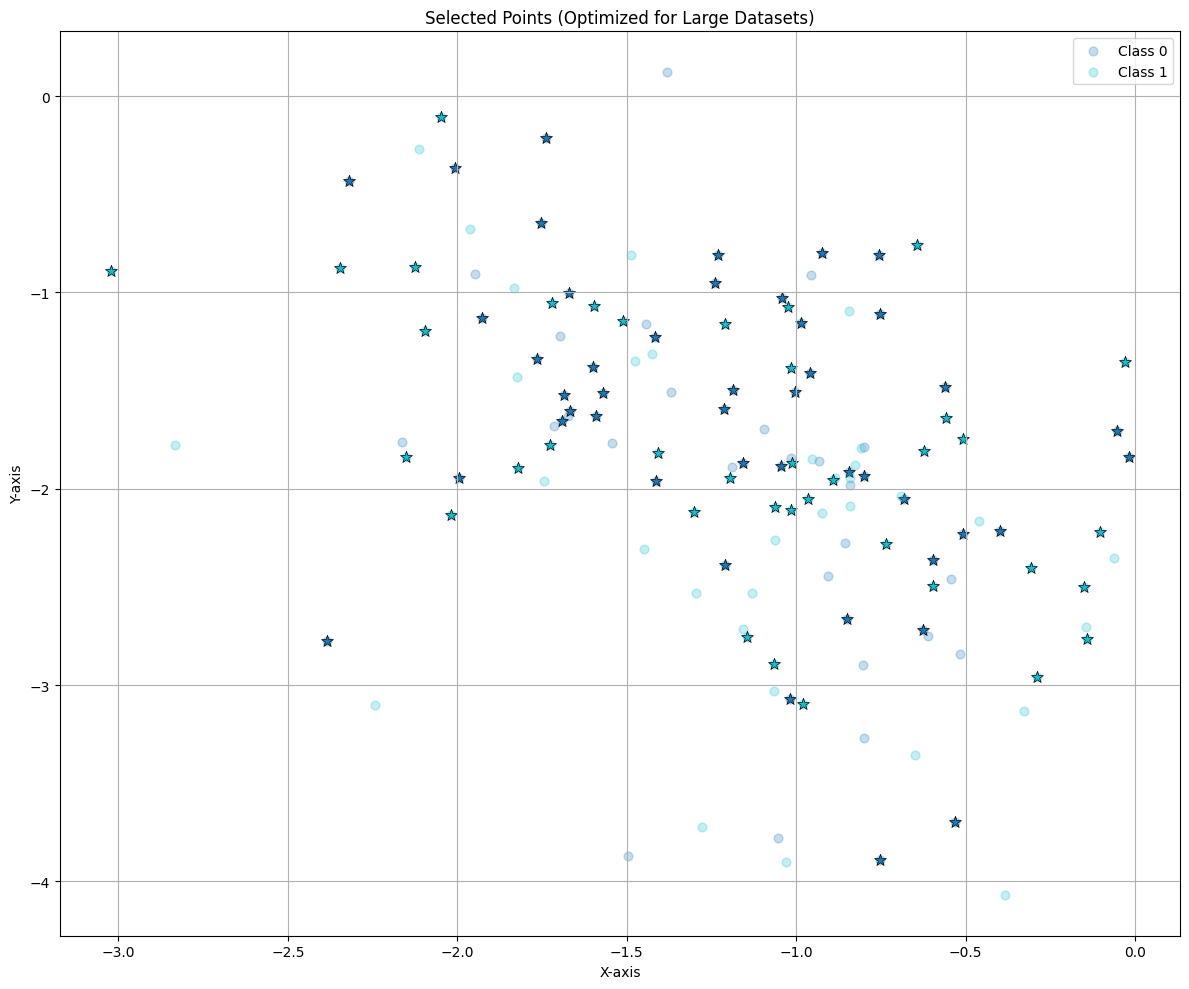

In [91]:
plot_selected_instances(X_filtered, y_filtered, selected_points) # parece que va bien, tengo que relajar penalizaciones